In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import json

plt.style.use('plot_style.txt')

In [2]:
OBJECTIVE = "OBJECTIVE"
INEQUALITY_CONSTRAINT_ONE = "INEQUALITY_CONSTRAINT_ONE"
INEQUALITY_CONSTRAINT_TWO = "INEQUALITY_CONSTRAINT_TWO"

In [3]:
def process_ts_results(result_dir: str,
                       num_runs: int,
                       failure_val: float):
    all_results = []
    for run in range(num_runs):
        run_file = result_dir + f"run_{run}_data.pkl"
        with open(run_file, "rb") as fp:
            run_data = pickle.load(fp)
        inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
        inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
        satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
        failure_mask = np.logical_not(satisfied_mask)
        objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
        objective_vals = objective_vals * 10000
        safe_obs_values = objective_vals.copy()
        safe_obs_values[failure_mask] = failure_val
        all_results.append(np.minimum.accumulate(safe_obs_values))
    all_results = np.array(all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [4]:
def process_original_albo_results(result_dir: str,
                                  num_runs: int,
                                  failure_val: float):
    all_results = []
    for run in range(1, num_runs + 1):
        run_file = result_dir + f"run_{run}_results.json"
        with open(run_file, "rb") as fp:
            all_run_data = json.load(fp)
            run_results = all_run_data["prog"]
            i = 0
            while run_results[i] == "Inf":
                i += 1
            if i > 0:
                for j in range(i):
                    run_results[j] = failure_val
            run_results = run_results
            all_results.append(np.minimum.accumulate(run_results))
    all_results = np.array(all_results)
    all_results = np.multiply(all_results, 10000)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [5]:
eci_known_obj_results, eci_known_obj_results_mean, eci_known_obj_results_median, eci_known_obj_results_std = process_ts_results("../results/eci_results/lockwood_known_objective/data/", 30, 62000)
eci_results, eci_results_mean, eci_results_median, eci_results_std = process_ts_results("../results/eci_results/lockwood/data/", 30, 62000)
original_albo_no_slack_results, original_albo_no_slack_results_mean, original_albo_no_slack_results_median, original_albo_no_slack_results_std = process_original_albo_results("../results/final_original_results/lockwood/no_slack/data/", 30, 6.2)
original_albo_no_slack_no_ey_results, original_albo_no_slack_no_ey_results_mean, original_albo_no_slack_no_ey_results_median, original_albo_no_slack_no_ey_results_std = process_original_albo_results("../results/final_original_results/lockwood/no_slack_no_ey/data/", 30, 6.2)
original_albo_slack_optim_results, original_albo_slack_optim_results_mean, original_albo_slack_optim_results_median, original_albo_slack_optim_results_std = process_original_albo_results("../results/final_original_results/lockwood/slack_optim/data/", 30, 6.2)
original_albo_slack_optim_no_ey_results, original_albo_slack_optim_no_ey_results_mean, original_albo_slack_optim_no_ey_results_median, original_albo_slack_optim_no_ey_results_std = process_original_albo_results("../results/final_original_results/lockwood/slack_optim_no_ey/data/", 30, 6.2)
original_albo_slack_no_optim_results, original_albo_slack_no_optim_results_mean, original_albo_slack_no_optim_results_median, original_albo_slack_no_optim_results_std = process_original_albo_results("../results/final_original_results/lockwood/slack_no_optim/data/", 30, 6.2)
original_albo_slack_no_optim_no_ey_results, original_albo_slack_no_optim_no_ey_results_mean, original_albo_slack_no_optim_no_ey_results_median, original_albo_slack_no_optim_no_ey_results_std = process_original_albo_results("../results/final_original_results/lockwood/slack_no_optim_no_ey/data/", 30, 6.2)
random_results, random_results_mean, random_results_median, random_results_std = process_ts_results("../results/20-04-23/lockwood_random/data/", 30, 62000)
ts_al_random_rbf_random_init_results, ts_al_random_rbf_random_init_results_mean, ts_al_random_rbf_random_init_results_median, ts_al_random_rbf_random_init_results_std = process_ts_results("../results/final_ts_results/lockwood/no_opt_rbf_uniform_random/data/", 30, 62000)
ts_al_adam_no_prev_rbf_batch_results, ts_al_adam_no_prev_rbf_batch_results_mean, ts_al_adam_no_prev_rbf_batch_results_median, ts_al_adam_no_prev_rbf_batch_results_std = process_ts_results("../results/final_ts_results/lockwood/adam_no_prev_rbf_batch_five/data/", 30, 62000)
ts_al_adam_no_prev_rbf_batch_random_init_results, ts_al_adam_no_prev_rbf_batch_random_init_results_mean, ts_al_adam_no_prev_rbf_batch_random_init_results_median, ts_al_adam_no_prev_rbf_batch_random_init_results_std = process_ts_results("../results/final_ts_results/lockwood/adam_no_prev_rbf_batch_five_uniform_random/data/", 30, 62000)
ts_al_adam_no_prev_rbf_random_init_results, ts_al_adam_no_prev_rbf_random_init_results_mean, ts_al_adam_no_prev_rbf_random_init_results_median, ts_al_adam_no_prev_rbf_random_init_results_std = process_ts_results("../results/final_ts_results/lockwood/adam_no_prev_rbf_uniform_random/data/", 30, 62000)

2023-06-04 18:55:53.140538: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-04 18:56:00.000576: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


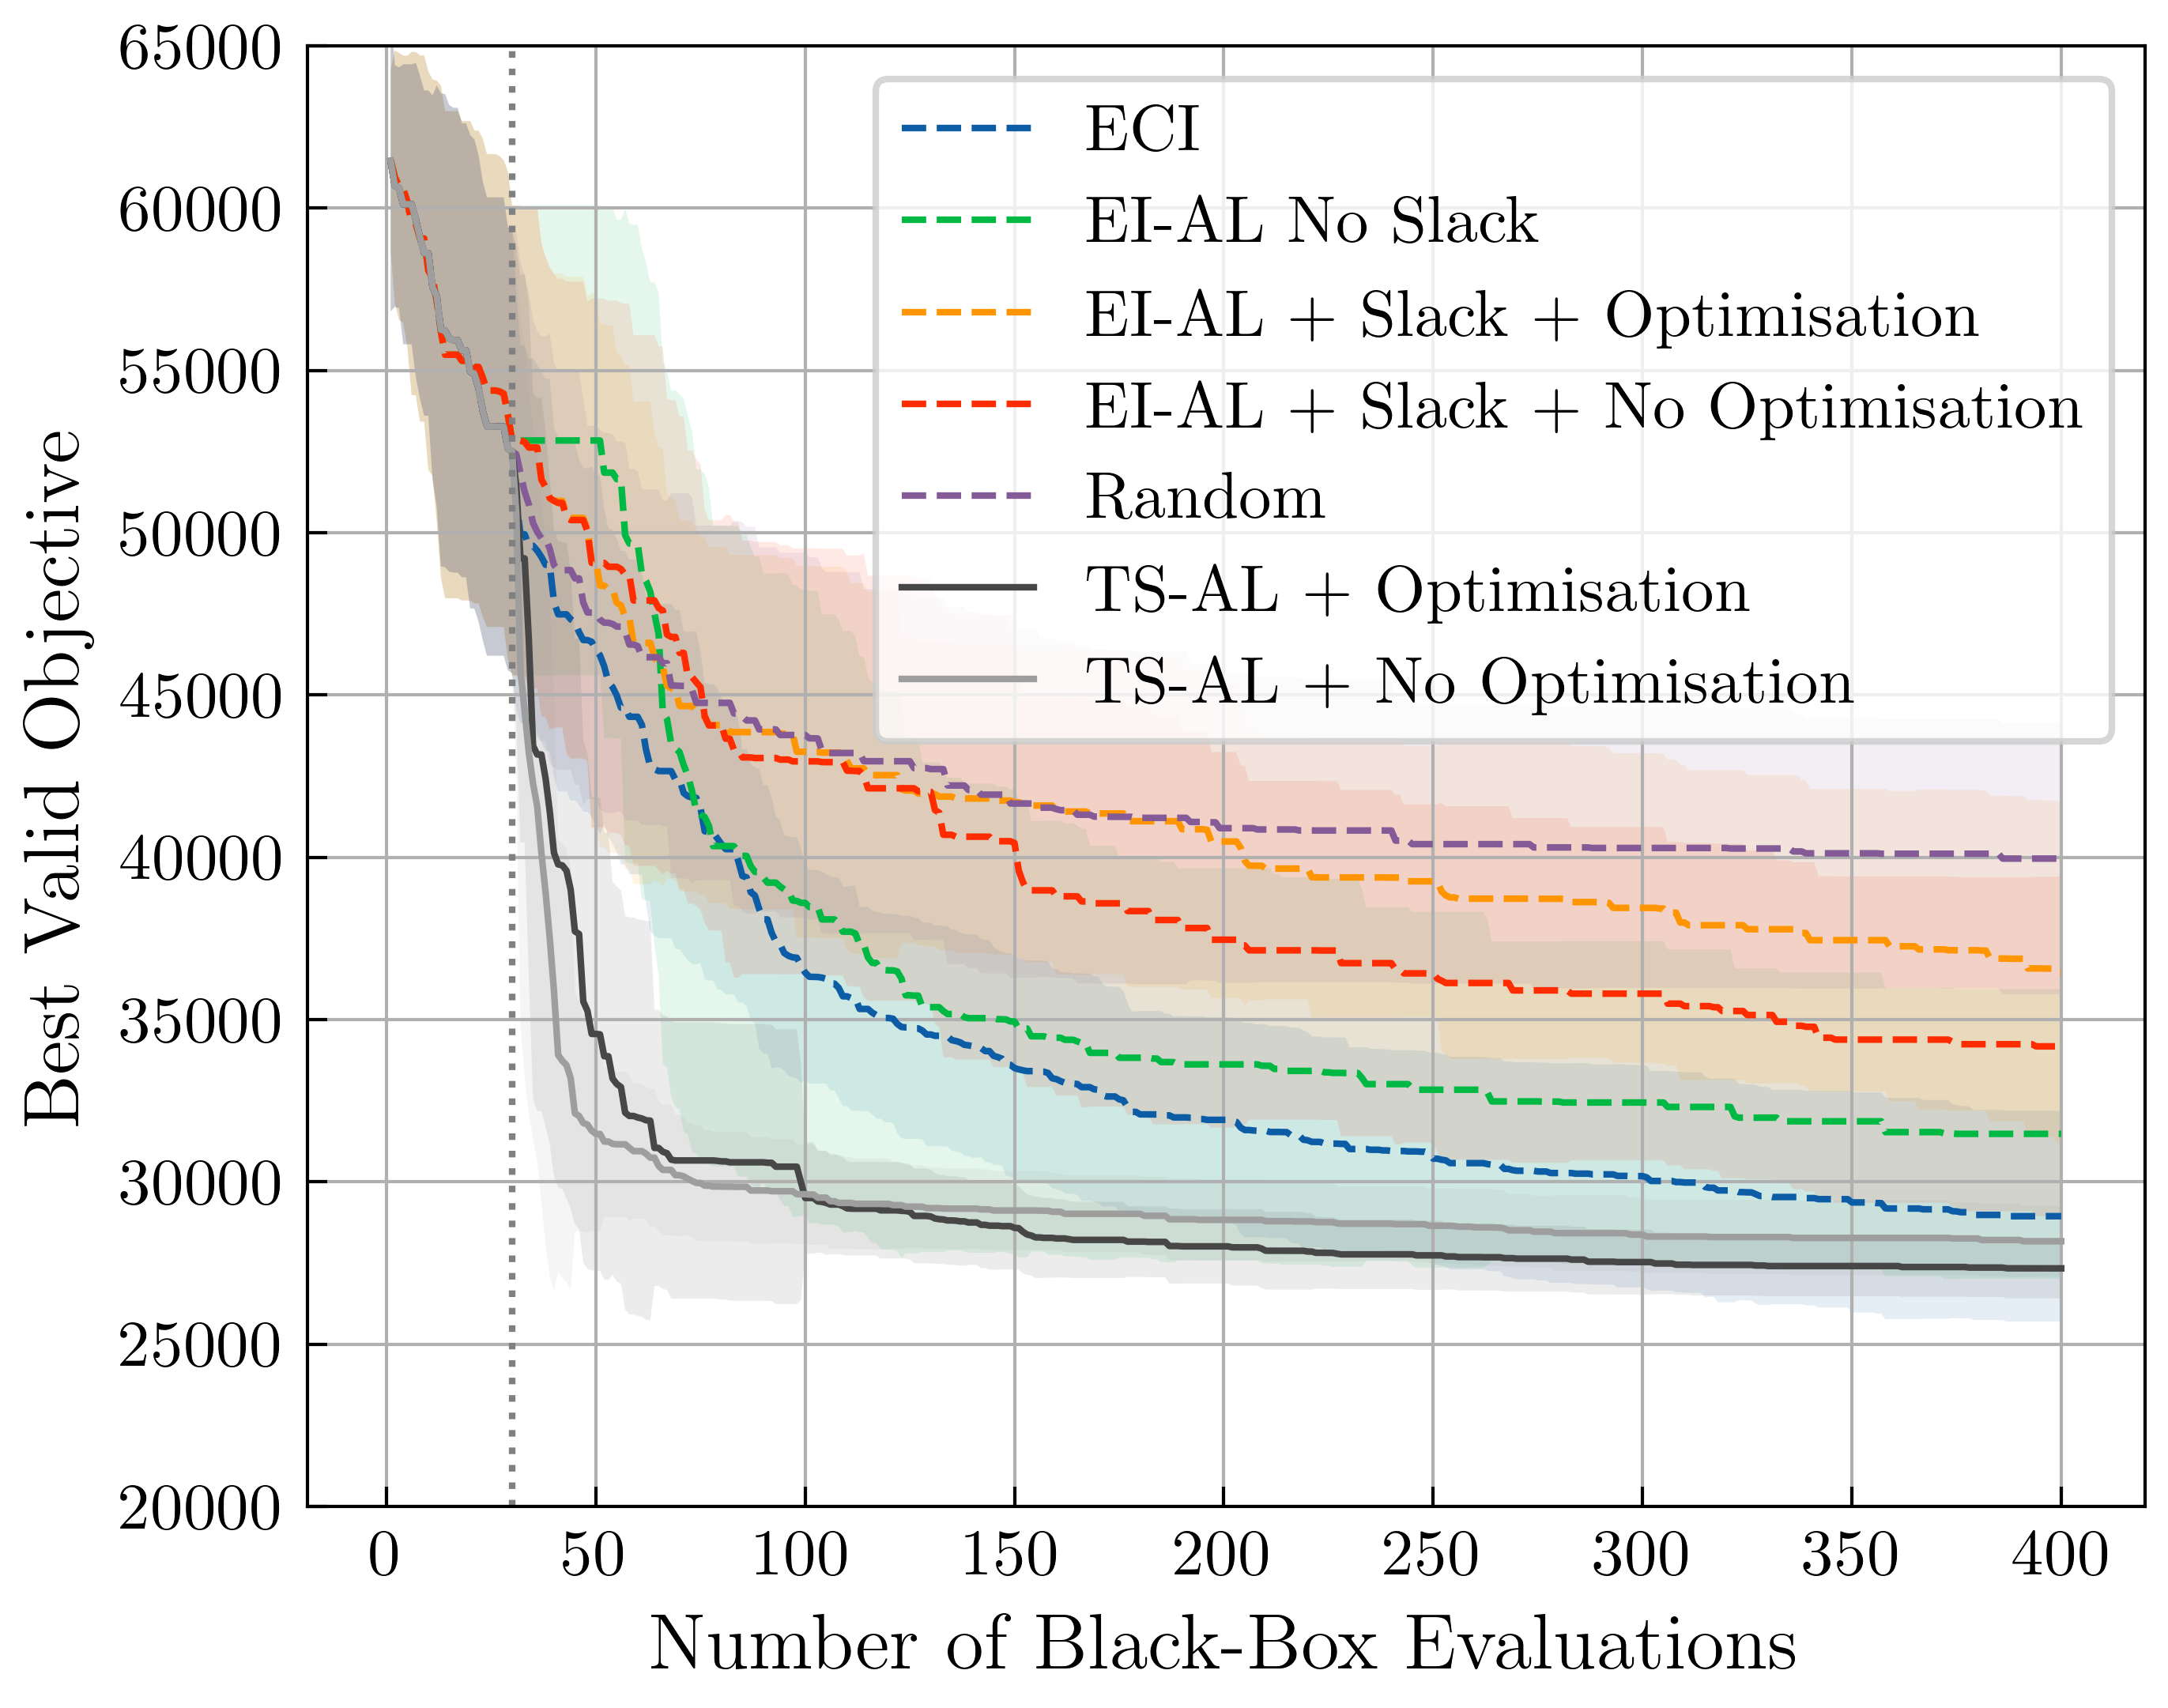

In [6]:
plt.figure(figsize=(5,4))
iters = [i for i in range(1, 401)]
plt.plot(iters, eci_known_obj_results_mean, label="ECI", linestyle="dashed")
plt.plot(iters, original_albo_no_slack_no_ey_results_mean, label="EI-AL No Slack", linestyle="dashed")
plt.plot(iters, original_albo_slack_optim_no_ey_results_mean, label="EI-AL + Slack + Optimisation", linestyle="dashed")
plt.plot(iters, original_albo_slack_no_optim_no_ey_results_mean, label="EI-AL + Slack + No Optimisation", linestyle="dashed")
plt.plot(iters, random_results_mean[:400], label="Random", linestyle="dashed")
plt.plot(iters, ts_al_adam_no_prev_rbf_random_init_results_mean, label="TS-AL + Optimisation")
plt.plot(iters, ts_al_random_rbf_random_init_results_mean, label="TS-AL + No Optimisation")
plt.axvline(x=30, color='grey', linestyle='dotted')
plt.fill_between(iters, eci_known_obj_results_mean+eci_known_obj_results_std, eci_known_obj_results_mean-eci_known_obj_results_std, alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, original_albo_no_slack_no_ey_results_mean+original_albo_no_slack_no_ey_results_std, original_albo_no_slack_no_ey_results_mean-original_albo_no_slack_no_ey_results_std, alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, original_albo_slack_optim_no_ey_results_mean+original_albo_slack_optim_no_ey_results_std, original_albo_slack_optim_no_ey_results_mean-original_albo_slack_optim_no_ey_results_std, alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, original_albo_slack_no_optim_no_ey_results_mean+original_albo_slack_no_optim_no_ey_results_std, original_albo_slack_no_optim_no_ey_results_mean-original_albo_slack_no_optim_no_ey_results_std, alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, random_results_mean[:400]+random_results_std[:400], random_results_mean[:400]-random_results_std[:400], alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, ts_al_adam_no_prev_rbf_random_init_results_mean+ts_al_adam_no_prev_rbf_random_init_results_std, ts_al_adam_no_prev_rbf_random_init_results_mean-ts_al_adam_no_prev_rbf_random_init_results_std, alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, ts_al_random_rbf_random_init_results_mean+ts_al_random_rbf_random_init_results_std, ts_al_random_rbf_random_init_results_mean-ts_al_random_rbf_random_init_results_std, alpha=0.1, linestyle='-', linewidth=2)
plt.ylim(20000, 65000)
plt.xlabel('Number of Black-Box Evaluations')
plt.ylabel('Best Valid Objective')
plt.legend()
# plt.savefig("figs/lockwood_results.png")
plt.show()

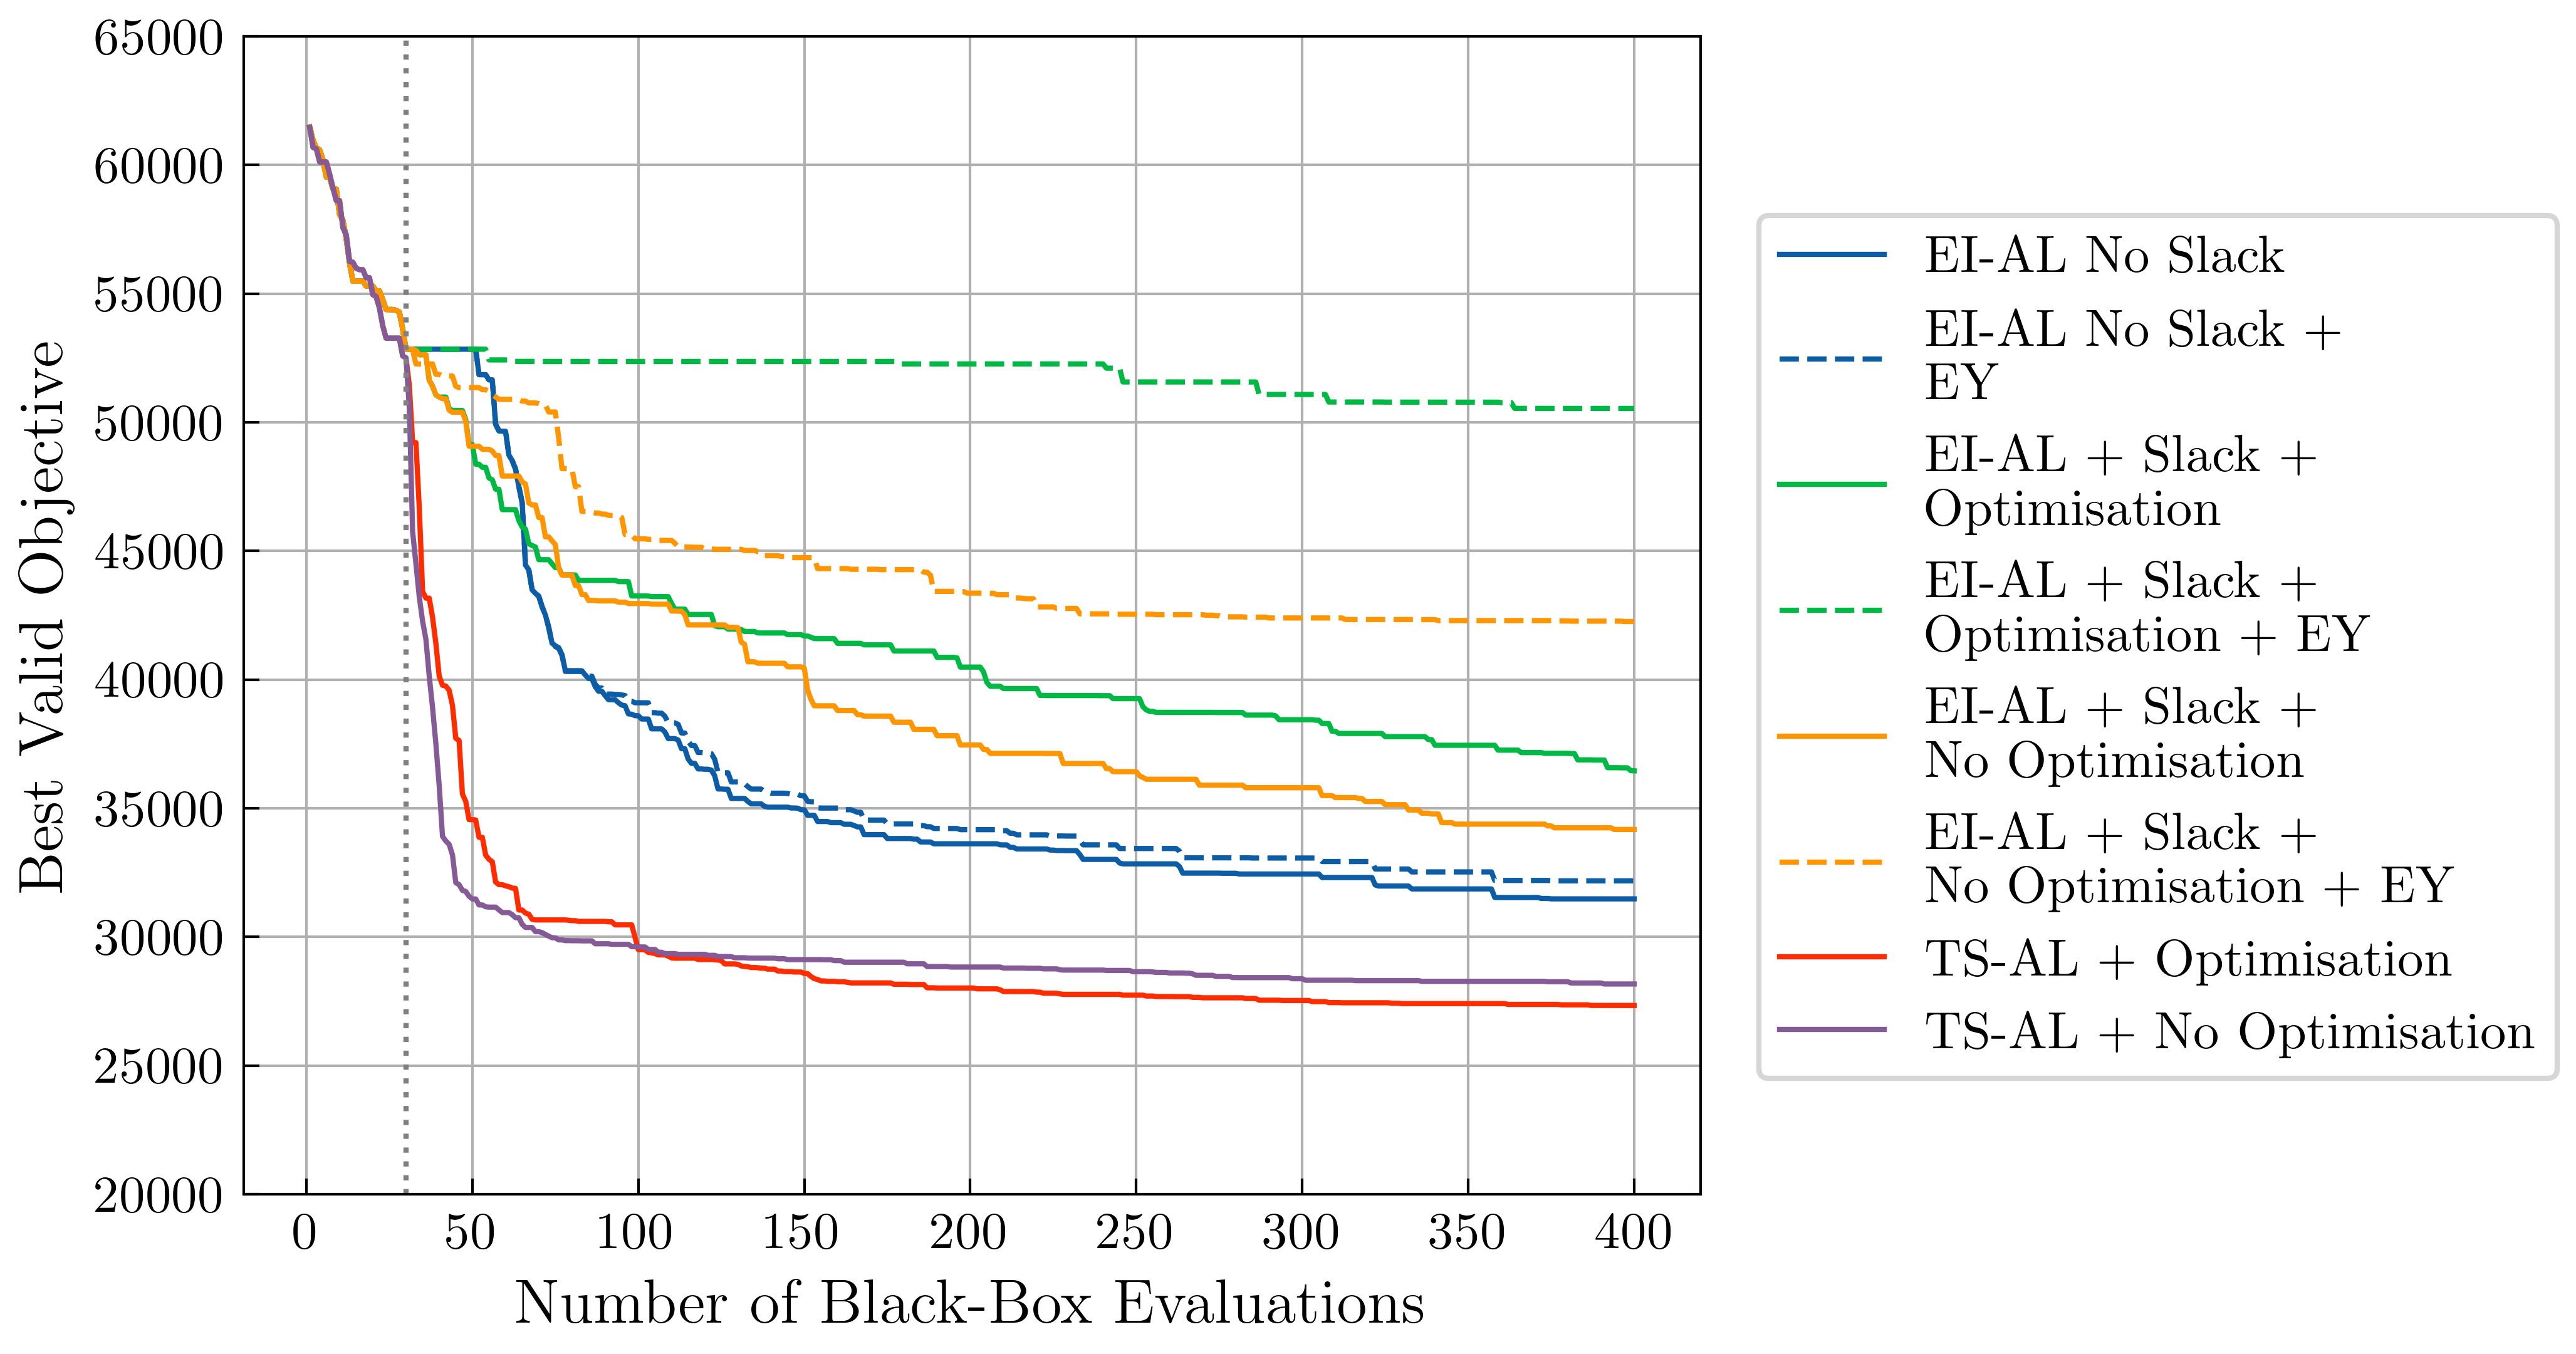

In [7]:
# EY Comparison
plt.figure(figsize=(5,4))
iters = [i for i in range(1, 401)]
no_slack, = plt.plot(iters, original_albo_no_slack_no_ey_results_mean, label="EI-AL No Slack")
plt.plot(iters, original_albo_no_slack_results_mean, label="EI-AL No Slack + \n EY", color=no_slack.get_color(), linestyle="dashed")
slack_optim, = plt.plot(iters, original_albo_slack_optim_no_ey_results_mean, label="EI-AL + Slack + \n Optimisation")
plt.plot(iters, original_albo_slack_optim_results_mean, label="EI-AL + Slack + \n Optimisation + EY", color=slack_optim.get_color(), linestyle="dashed")
slack_no_optim, = plt.plot(iters, original_albo_slack_no_optim_no_ey_results_mean, label="EI-AL + Slack + \n No Optimisation")
plt.plot(iters, original_albo_slack_no_optim_results_mean, label="EI-AL + Slack + \n No Optimisation + EY", color=slack_no_optim.get_color(), linestyle="dashed")
plt.plot(iters, ts_al_adam_no_prev_rbf_random_init_results_mean, label="TS-AL + Optimisation")
plt.plot(iters, ts_al_random_rbf_random_init_results_mean, label="TS-AL + No Optimisation")
plt.axvline(x=30, color='grey', linestyle='dotted')
plt.ylim(20000, 65000)
plt.xlabel('Number of Black-Box Evaluations')
plt.ylabel('Best Valid Objective')
legend = plt.legend(loc=(1.04, 0.1))
# plt.savefig("figs/lockwood_ey_results.png")
plt.show()

In [8]:
key_iterations = [100, 250, 400]

In [9]:
# ECI Known Objective
for iter in key_iterations:
    print(f"Iter: {iter}")
    print(f"5%: {np.percentile(eci_known_obj_results, 5, axis=0)[iter-1]}, Median: {eci_known_obj_results_median[iter-1]}, 95%: {np.percentile(eci_known_obj_results, 95, axis=0)[iter-1]}")

Iter: 100
5%: 31162.518, Median: 36117.285, 95%: 42005.100999999995
Iter: 250
5%: 26844.627500000002, Median: 29611.08, 95%: 36920.553499999995
Iter: 400
5%: 25684.422499999997, Median: 27993.96, 95%: 35498.7445


In [10]:
# TS-AL Optim Uniform Random Initialisation
for iter in key_iterations:
    print(f"Iter: {iter}")
    print(f"5%: {np.percentile(ts_al_adam_no_prev_rbf_random_init_results, 5, axis=0)[iter-1]}, Median: {ts_al_adam_no_prev_rbf_random_init_results_median[iter-1]}, 95%: {np.percentile(ts_al_adam_no_prev_rbf_random_init_results, 95, axis=0)[iter-1]}")

Iter: 100
5%: 27442.814000000002, Median: 29390.975, 95%: 31962.296499999997
Iter: 250
5%: 25753.28, Median: 27743.17, 95%: 29315.406
Iter: 400
5%: 25628.408, Median: 27414.265, 95%: 28926.182


In [11]:
# TS-AL No Optim Uniform Random Initialisation
for iter in key_iterations:
    print(f"Iter: {iter}")
    print(f"5%: {np.percentile(ts_al_random_rbf_random_init_results, 5, axis=0)[iter-1]}, Median: {ts_al_random_rbf_random_init_results_median[iter-1]}, 95%: {np.percentile(ts_al_random_rbf_random_init_results, 95, axis=0)[iter-1]}")

Iter: 100
5%: 27282.6855, Median: 29886.015, 95%: 31957.6305
Iter: 250
5%: 26770.191, Median: 28785.245000000003, 95%: 30450.365999999998
Iter: 400
5%: 26442.689, Median: 28147.305, 95%: 30041.2795


In [12]:
# EI-AL No Slack No EY
for iter in key_iterations:
    print(f"Iter: {iter}")
    print(f"5%: {np.percentile(original_albo_no_slack_no_ey_results, 5, axis=0)[iter-1]}, Median: {original_albo_no_slack_no_ey_results_median[iter-1]}, 95%: {np.percentile(original_albo_no_slack_no_ey_results, 95, axis=0)[iter-1]}")

Iter: 100
5%: 26610.3445, Median: 39645.215, 95%: 53383.322499999995
Iter: 250
5%: 25816.47, Median: 33273.515, 95%: 42538.84649999999
Iter: 400
5%: 25388.6095, Median: 31900.405, 95%: 37914.39


In [13]:
# EI-AL No Slack
for iter in key_iterations:
    print(f"Iter: {iter}")
    print(f"5%: {np.percentile(original_albo_no_slack_results, 5, axis=0)[iter-1]}, Median: {original_albo_no_slack_results_median[iter-1]}, 95%: {np.percentile(original_albo_no_slack_results, 95, axis=0)[iter-1]}")

Iter: 100
5%: 27953.37, Median: 39645.215, 95%: 53383.322499999995
Iter: 250
5%: 26763.466500000002, Median: 33288.105, 95%: 42538.84649999999
Iter: 400
5%: 26763.466500000002, Median: 32859.024999999994, 95%: 37914.39


In [14]:
# EI-AL Slack No Optim No EY
for iter in key_iterations:
    print(f"Iter: {iter}")
    print(f"5%: {np.percentile(original_albo_slack_no_optim_no_ey_results, 5, axis=0)[iter-1]}, Median: {original_albo_slack_no_optim_no_ey_results_median[iter-1]}, 95%: {np.percentile(original_albo_slack_no_optim_no_ey_results, 95, axis=0)[iter-1]}")

Iter: 100
5%: 31866.028000000002, Median: 41921.615, 95%: 52095.25499999999
Iter: 250
5%: 28321.787500000002, Median: 37023.925, 95%: 43699.4995
Iter: 400
5%: 27326.092999999997, Median: 35157.41, 95%: 42827.7975


In [15]:
# EI-AL Slack Optim No EY
for iter in key_iterations:
    print(f"Iter: {iter}")
    print(f"5%: {np.percentile(original_albo_slack_optim_no_ey_results, 5, axis=0)[iter-1]}, Median: {original_albo_slack_optim_no_ey_results_median[iter-1]}, 95%: {np.percentile(original_albo_slack_optim_no_ey_results, 95, axis=0)[iter-1]}")

Iter: 100
5%: 34835.103, Median: 41921.615, 95%: 50497.436
Iter: 250
5%: 31510.99, Median: 39840.575, 95%: 45451.1395
Iter: 400
5%: 28813.8635, Median: 37263.92, 95%: 43988.1475


In [16]:
# EI-AL Slack Optim
for iter in key_iterations:
    print(f"Iter: {iter}")
    print(f"5%: {np.percentile(original_albo_slack_optim_results, 5, axis=0)[iter-1]}, Median: {original_albo_slack_optim_results_median[iter-1]}, 95%: {np.percentile(original_albo_slack_optim_results, 95, axis=0)[iter-1]}")

Iter: 100
5%: 41683.754, Median: 50636.82, 95%: 62000.0
Iter: 250
5%: 41683.754, Median: 50320.08500000001, 95%: 62000.0
Iter: 400
5%: 41099.8585, Median: 50226.065, 95%: 62000.0


In [17]:
# Random
for iter in key_iterations:
    print(f"Iter: {iter}")
    print(f"5%: {np.percentile(random_results, 5, axis=0)[iter-1]}, Median: {random_results_median[iter-1]}, 95%: {np.percentile(random_results, 95, axis=0)[iter-1]}")

Iter: 100
5%: 33752.679500000006, Median: 44677.130000000005, 95%: 51382.53299999999
Iter: 250
5%: 31810.952000000005, Median: 40938.12, 95%: 45908.256
Iter: 400
5%: 31810.952000000005, Median: 40508.05, 95%: 45908.256


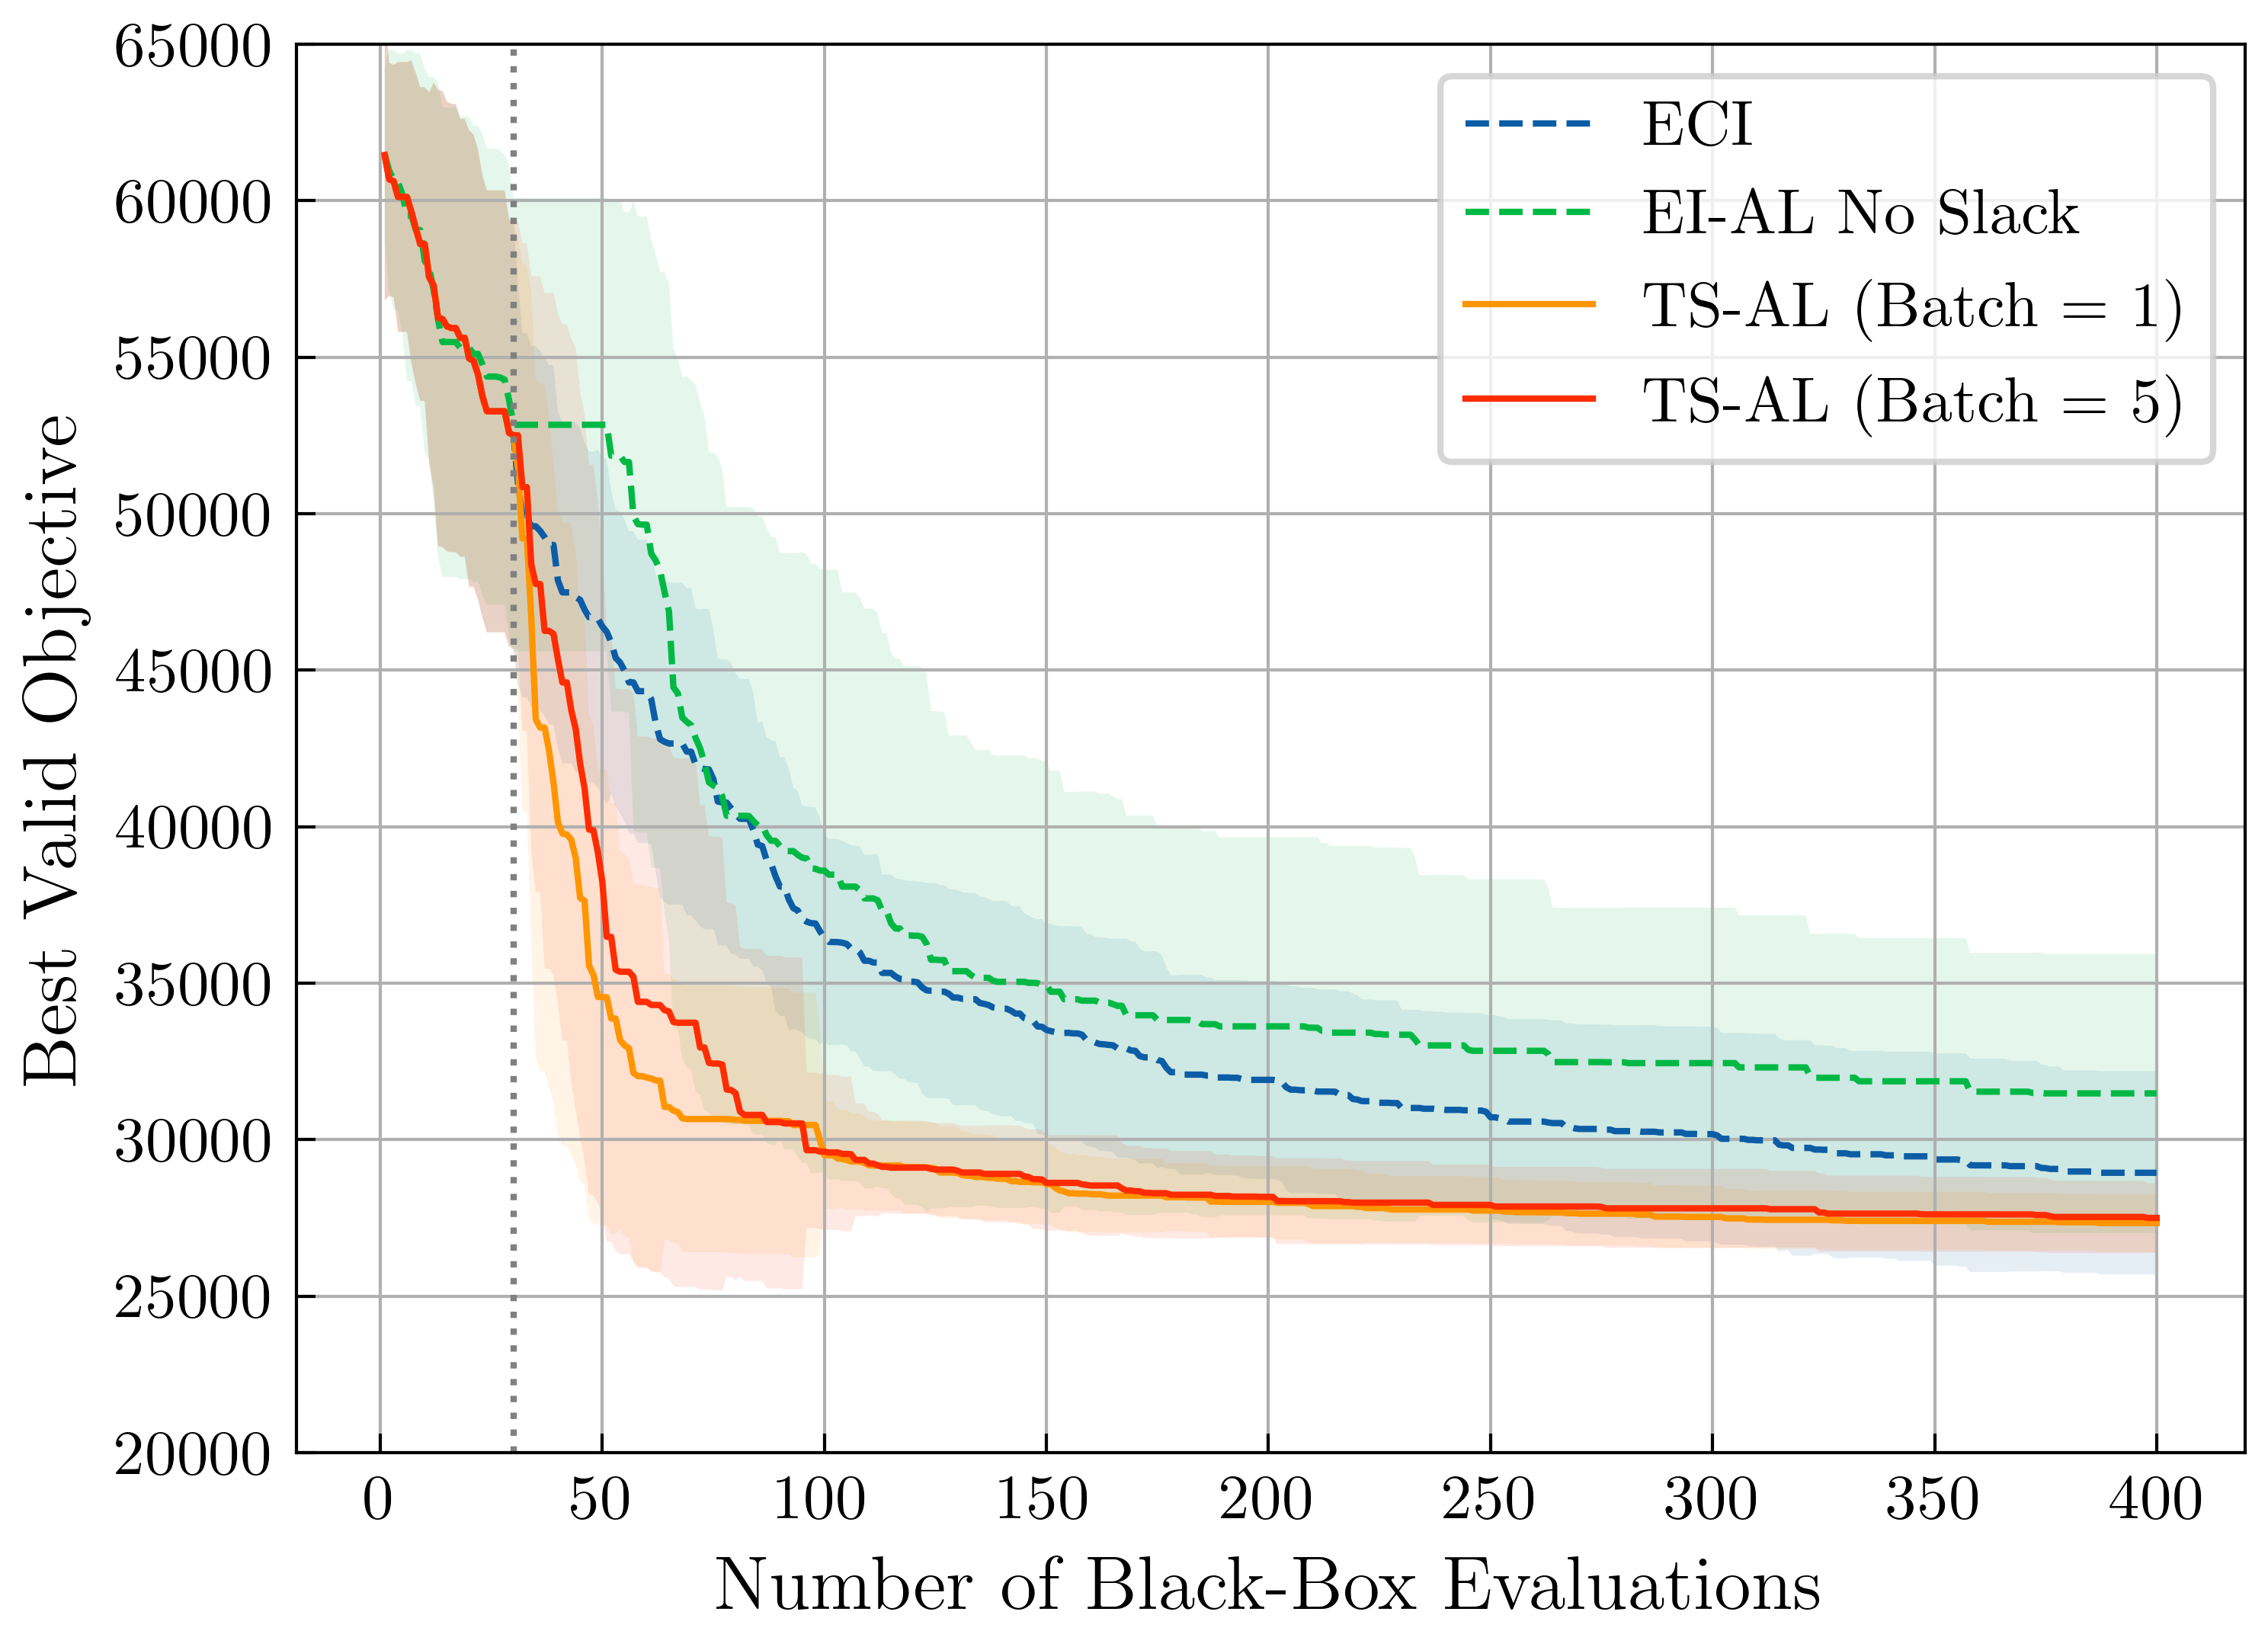

In [19]:
plt.figure(figsize=(5.5,4))
iters = [i for i in range(1, 401)]
plt.plot(iters, eci_known_obj_results_mean, label="ECI", linestyle="dashed")
plt.plot(iters, original_albo_no_slack_no_ey_results_mean, label="EI-AL No Slack", linestyle="dashed")
plt.plot(iters, ts_al_adam_no_prev_rbf_random_init_results_mean, label="TS-AL (Batch = 1)")
plt.plot(iters, ts_al_adam_no_prev_rbf_batch_random_init_results_mean, label="TS-AL (Batch = 5)")
plt.axvline(x=30, color='grey', linestyle='dotted')
plt.fill_between(iters, eci_known_obj_results_mean+eci_known_obj_results_std, eci_known_obj_results_mean-eci_known_obj_results_std, alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, original_albo_no_slack_no_ey_results_mean+original_albo_no_slack_no_ey_results_std, original_albo_no_slack_no_ey_results_mean-original_albo_no_slack_no_ey_results_std, alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, ts_al_adam_no_prev_rbf_random_init_results_mean+ts_al_adam_no_prev_rbf_random_init_results_std, ts_al_adam_no_prev_rbf_random_init_results_mean-ts_al_adam_no_prev_rbf_random_init_results_std, alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, ts_al_adam_no_prev_rbf_batch_random_init_results_mean+ts_al_adam_no_prev_rbf_batch_random_init_results_std, ts_al_adam_no_prev_rbf_batch_random_init_results_mean-ts_al_adam_no_prev_rbf_batch_random_init_results_std, alpha=0.1, linestyle='-', linewidth=2)
plt.ylim(20000, 65000)
plt.xlabel('Number of Black-Box Evaluations')
plt.ylabel('Best Valid Objective')
plt.legend()
plt.savefig("figs/lockwood_batch_black_box_results.png")
plt.show()

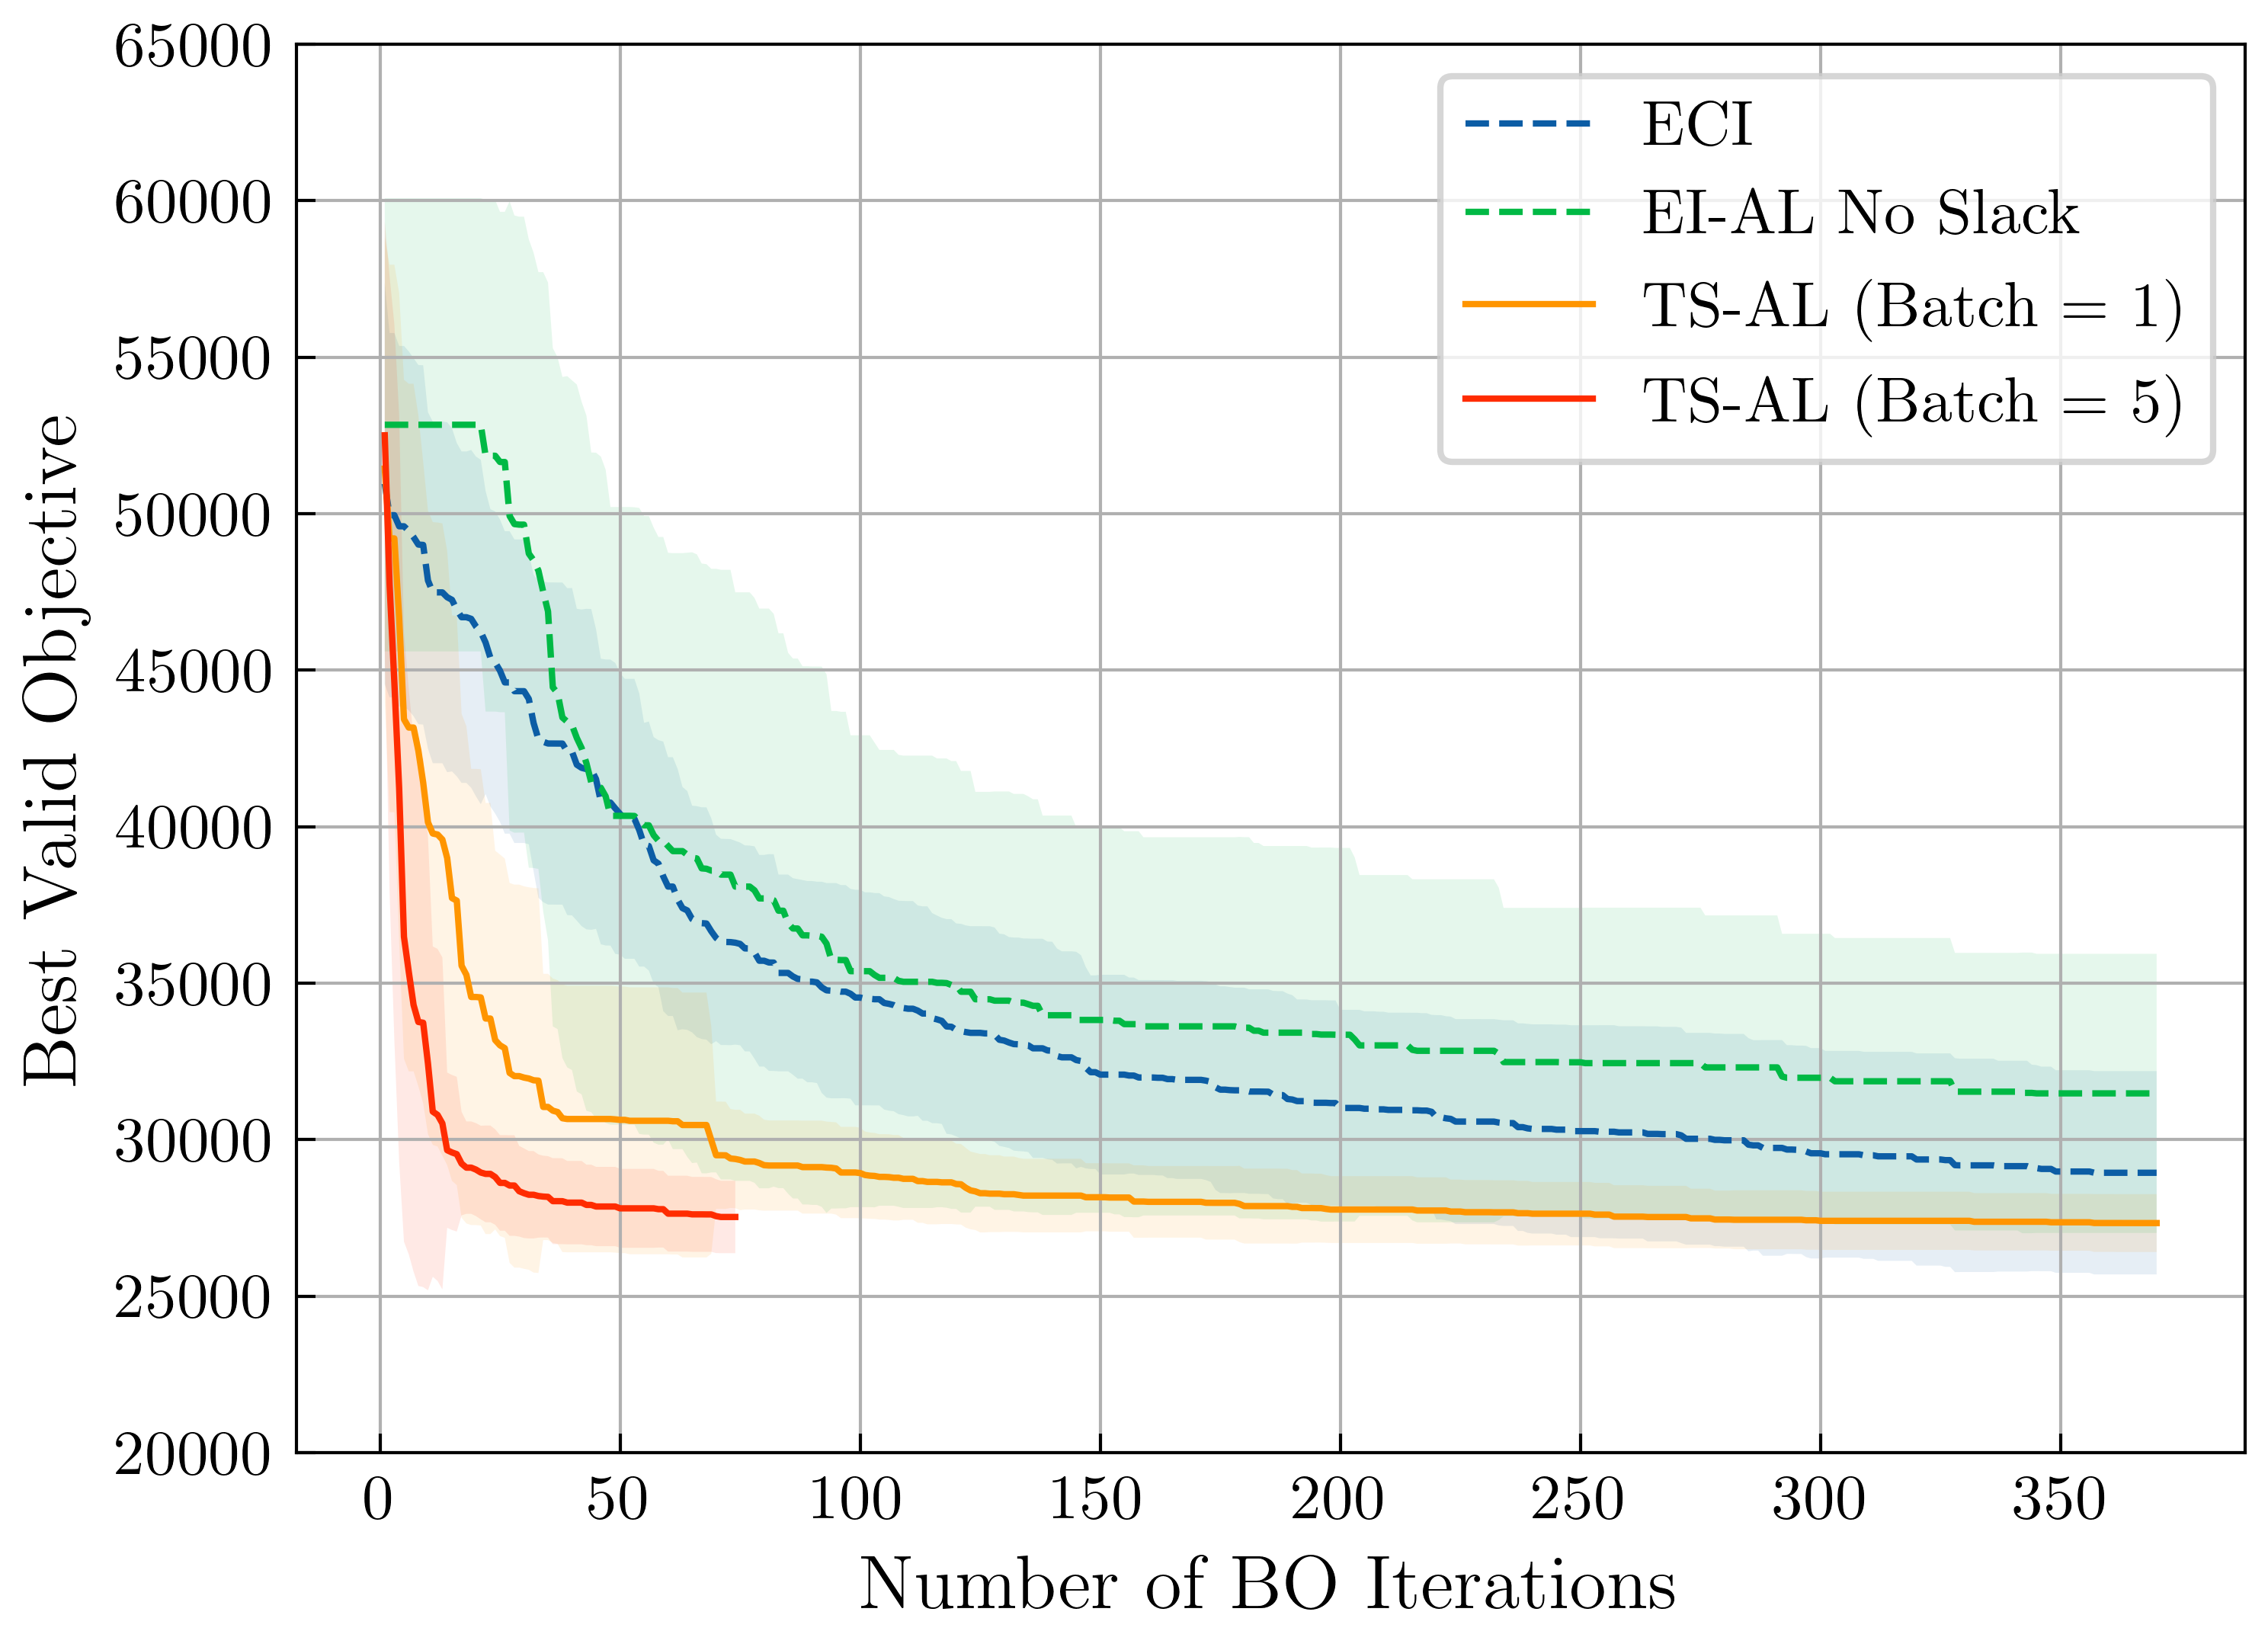

In [20]:
plt.figure(figsize=(5.5,4))
iters = [i for i in range(1, 371)]
batch_iters = [i for i in range(1, 75)]
plt.plot(iters, eci_known_obj_results_mean[30:], label="ECI", linestyle="dashed")
plt.plot(iters, original_albo_no_slack_no_ey_results_mean[30:], label="EI-AL No Slack", linestyle="dashed")
plt.plot(iters, ts_al_adam_no_prev_rbf_random_init_results_mean[30:], label="TS-AL (Batch = 1)")
plt.plot(batch_iters, ts_al_adam_no_prev_rbf_batch_random_init_results_mean[30::5], label="TS-AL (Batch = 5)")
plt.fill_between(iters, eci_known_obj_results_mean[30:]+eci_known_obj_results_std[30:], eci_known_obj_results_mean[30:]-eci_known_obj_results_std[30:], alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, original_albo_no_slack_no_ey_results_mean[30:]+original_albo_no_slack_no_ey_results_std[30:], original_albo_no_slack_no_ey_results_mean[30:]-original_albo_no_slack_no_ey_results_std[30:], alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, ts_al_adam_no_prev_rbf_random_init_results_mean[30:]+ts_al_adam_no_prev_rbf_random_init_results_std[30:], ts_al_adam_no_prev_rbf_random_init_results_mean[30:]-ts_al_adam_no_prev_rbf_random_init_results_std[30:], alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(batch_iters, ts_al_adam_no_prev_rbf_batch_random_init_results_mean[30::5]+ts_al_adam_no_prev_rbf_batch_random_init_results_std[30::5], ts_al_adam_no_prev_rbf_batch_random_init_results_mean[30::5]-ts_al_adam_no_prev_rbf_batch_random_init_results_std[30::5], alpha=0.1, linestyle='-', linewidth=2)
plt.ylim(20000, 65000)
plt.xlabel('Number of BO Iterations')
plt.ylabel('Best Valid Objective')
plt.legend()
plt.savefig("figs/lockwood_batch_bo_results.png")
plt.show()